# Implement HiTS-EQ in python - both Equation and curve fitting solutions
Hsuan-Chun Lin 2023.03

In this version, multiple points are supported. You can use different number of concentrations without change any parameters in the sourcecode.
## Curve Fitting Solution - recommended
### Import necessary packages

In [187]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy import stats
from functools import partial
import seaborn as sns
import matplotlib.pylab as plt

### Import data in csv format and fetch the binding fractions

In [166]:
df = pd.read_csv("input_data.csv", header=0)
df.head()

,Seq,1,2,3,4
0,f,0,0.25,0.5,0.75
1,[E],0,6.67,20.0,60.00
2,AAAAAA,4133,1425.00,1754.0,1422.00
3,AAAAAC,2662,1049.00,998.0,953.00
4,AAAAAG,5247,2726.00,2612.0,2322.00


### Data format preprocessing

In [167]:
enzyme_concentration =  df.iloc[1,1:]
binding_fraction = 1 - df.iloc[0,1:].astype(float)
sequence_count = df.iloc[2:,1:]
library = df.iloc[2:,0].reset_index().drop("index",axis=1)

### Define fitting function
$$f = 1 -( \frac{D_{t}}{D_t1}\times (1-frac) \times \frac{D_1}{D_0})= \frac{E}{E+K_D}$$

Calculate $$ D_t $$ and $$D_{t1}$$

In [168]:
Dt_all = sequence_count.sum()
Dt_Dt1_all = Dt_all[0]/Dt_all
#Dt_Dt1_all


In [169]:
D0_ = sequence_count.iloc[:,0]
D1fD0 = sequence_count.divide(D0_,axis='rows')
fitting_table = 1 - (Dt_Dt1_all * binding_fraction * D1fD0)
fitting_table[fitting_table < 0] = np.random.randint(1,9)/100000
fitting_table = fitting_table.reset_index()
fitting_table = fitting_table.drop("index",axis = 1)

### Define fitting equations and implement it by curve_fit and partial functions

In [170]:
def HitsEQ(x, K):
    return x/(x+K)

def curvefit(func, x, y, k_initial):
    return tuple(curve_fit(HitsEQ, x, y, p0=k_initial))

In [171]:
k_initial = 1
fit = partial(curvefit, HitsEQ, enzyme_concentration, k_initial=k_initial)

### Fit your data and get results

In [172]:
K = fitting_table.apply(fit, axis=1).apply(pd.Series)


In [173]:
K.columns = ["K", "pcov"]
finalresult = K.explode(["K", "pcov"]).explode("pcov").reset_index().drop("index", axis = 1)
finalresult[["id"]] = library
finalresult[["KA"]] = (1/finalresult.K).apply(pd.Series)
finalresult.head()

,K,pcov,id,KA
0,7.96889,2.596841,AAAAAA,0.125488
1,8.600381,0.477099,AAAAAC,0.116274
2,15.0288,0.144638,AAAAAG,0.066539
3,6.204218,0.366085,AAAAAT,0.161181
4,4.82366,0.054333,AAAACA,0.207311


### Calculate relative association constants

In [174]:
finalresult[["RKA"]] = (finalresult.KA/finalresult.KA[2]).apply(pd.Series)

In [175]:
finalresult.pcov.astype(float).describe(percentiles=[.25, .5, .75],include=all)

count    4096.000000
mean       89.932653
std       402.150746
min         0.000045
25%         0.074850
50%         0.454456
75%         5.380268
max      4152.733854
Name: pcov, dtype: float64

In [176]:
cols = ['id', 'K', 'KA', 'RKA', 'pcov']
finalresult = finalresult[cols]
filter = finalresult[(finalresult.pcov < 700)]
filter

,id,K,KA,RKA,pcov
0,AAAAAA,7.96889,0.125488,1.885934,2.596841
1,AAAAAC,8.600381,0.116274,1.747457,0.477099
2,AAAAAG,15.0288,0.066539,1.000000,0.144638
3,AAAAAT,6.204218,0.161181,2.422352,0.366085
4,AAAACA,4.82366,0.207311,3.115642,0.054333
...,...,...,...,...,...
4091,TTTTGT,4.338817,0.230478,3.463801,0.010832
4092,TTTTTA,5.607952,0.178318,2.679909,0.012251
4093,TTTTTC,6.969578,0.143481,2.156343,0.073797
4094,TTTTTG,8.721776,0.114656,1.723135,1.692652


## Equation solution - use unbound and one fraction point

$$ K_{2, rel} = \frac{E}{ \left( \frac{S_1}{S_2} \frac{S_{1,0}}{S_{2,0}}(1+E)\right)-1}$$

In [177]:
#Calculate S1/S2
S1 = sequence_count.iloc[2,:]
S10 = S1[0]
Step1 = 1/(sequence_count.divide(sequence_count.iloc[:,0], axis=0))
refs = S1/S1[0]
div_ = Step1 * refs * (1+enzyme_concentration) -1
rKd = enzyme_concentration/div_
RKA = 1/rKd
RKA = RKA.apply(pd.Series).reset_index()
RKA["id"] = library


In [178]:
plotdata = filter.merge(RKA, on="id", how='left')
plotdata.head()

,id,K,KA,RKA,pcov,index,1,2,3,4
0,AAAAAA,7.96889,0.125488,1.885934,2.596841,2,NaN,1.582821,1.18165,1.290995
1,AAAAAC,8.600381,0.116274,1.747457,0.477099,3,NaN,1.366137,1.344212,1.240072
2,AAAAAG,15.0288,0.066539,1.000000,0.144638,4,NaN,1.0,1.0,1.0
3,AAAAAT,6.204218,0.161181,2.422352,0.366085,5,NaN,1.646104,1.582885,1.774441
4,AAAACA,4.82366,0.207311,3.115642,0.054333,6,NaN,1.83052,2.135988,2.060999


/Users/fatmimi/.pyenv/versions/3.8.7/envs/mactf-sandbox/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 2.6437119782515577, 'R-squared: 0.95')

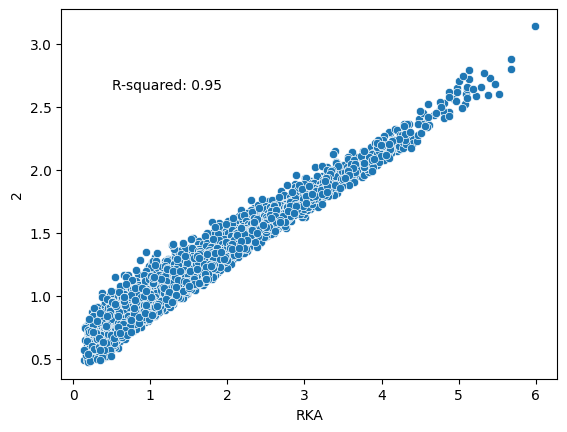

In [195]:
res = stats.linregress(plotdata.RKA.astype(float), plotdata.iloc[:,7].astype(float))
sns.scatterplot(plotdata.RKA, plotdata.iloc[:,7])
plt.text(0.5, plotdata.iloc[:,7].max()-0.5, f"R-squared: {res.rvalue**2:.2f}", horizontalalignment='left', size='medium', color='black')


/Users/fatmimi/.pyenv/versions/3.8.7/envs/mactf-sandbox/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='RKA', ylabel='2'>

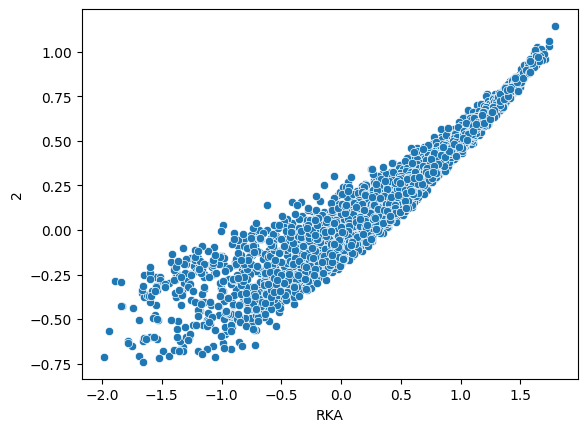

In [196]:
sns.scatterplot(np.log(plotdata.RKA.astype(float)),np.log(plotdata.iloc[:,7].astype(float)))